# Base year (2023) validation

This notebook validates the results of PyPSA-Earth for the base year (2023) against the **EIA (U.S. Energy Information Administration)** and **Ember** US datasets. The validation covers three key aspects of the electricity system:
- **Electricity Demand**
- **Electricity Generation**
- **Installed Generation Capacity**

## 1. Setup and Data Loading

*This section handles the initial setup, including importing necessary libraries and loading the solved PyPSA-Earth networks.*

### 11.1 Loading libraries

We begin by importing the necessary libraries for data handling, analysis, and visualization. These include PyPSA for power system analysis, pandas and numpy for data manipulation, geopandas for spatial data, and seaborn/matplotlib for plotting.

---

In [1]:
# Install required packages if not already installed
# Uncomment the line below to install packages
# Note: This line is commented out to prevent installation during code execution.

!pip install numpy pandas plotly pycountry matplotlib seaborn -qq

In [2]:
import os
import pypsa
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import pycountry

import warnings
warnings.filterwarnings("ignore")

/home/user/miniforge3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning:

The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 



### 1.2 Helper functions

In [3]:
def convert_two_country_code_to_three(country_code):
    """
    Convert a two-letter country code to a three-letter ISO country code.

    Args:
        country_code (str): Two-letter country code (ISO 3166-1 alpha-2).

    Returns:
        str: Three-letter country code (ISO 3166-1 alpha-3).
    """
    country = pycountry.countries.get(alpha_2=country_code)
    return country.alpha_3


def get_country_name(country_code):
    """ Input:
            country_code - two letter code of the country
        Output:
            country.name - corresponding name of the country
            country.alpha_3 - three letter code of the country
    """
    try:
        country = pycountry.countries.get(alpha_2=country_code)
        return country.name, country.alpha_3 if country else None
    except KeyError:
        return None
    

def get_data_EIA(data_path, country_code, year):
    """
    Retrieves energy generation data from the EIA dataset for a specified country and year.

    Args:
        data_path (str): Path to the EIA CSV file.
        country_code (str): Two-letter or three-letter country code (ISO).
        year (int or str): Year for which energy data is requested.

    Returns:
        pd.DataFrame: DataFrame containing energy generation data for the given country and year, 
                    or None if no matching country is found.
    """

    # Load EIA data from CSV file
    data = pd.read_csv(data_path)

    # Rename the second column to 'country' for consistency
    data.rename(columns={"Unnamed: 1": "country"}, inplace=True)

    # Remove leading and trailing spaces in the 'country' column
    data["country"] = data["country"].str.strip()

    # Extract the three-letter country code from the 'API' column
    data["code_3"] = data.dropna(subset=["API"])["API"].apply(
        lambda x: x.split('-')[2] if isinstance(x,
                                                str) and len(x.split('-')) > 3 else x
    )

    # Get the official country name and three-letter country code using the provided two-letter code
    country_name, country_code3 = get_country_name(country_code)

    # Check if the three-letter country code exists in the dataset
    if country_code3 and country_code3 in data.code_3.unique():
        # Retrieve the generation data for the specified year
        result = data.query("code_3 == @country_code3")[["country", str(year)]]

    # If not found by code, search by the country name
    elif country_name and country_name in data.country.unique():
        # Find the country index and retrieve generation data
        country_index = data.query("country == @country_name").index[0]
        result = data.iloc[country_index +
                           1:country_index+18][["country", str(year)]]

    else:
        # If no match is found, return None
        result = None

    # Convert the year column to float for numeric operations
    result[str(year)] = result[str(year)].astype(float)

    return result


def get_demand_ember(data, country_code, year):
    """
    Get the electricity demand for a given country and year from Ember data.

    Args:
        data (pd.DataFrame): Ember data.
        country_code (str): Country code (ISO 3166-1 alpha-2).
        year (int): Year of interest.

    Returns:
        float or None: Electricity demand if found, otherwise None.
    """
    demand = data[(data["Year"] == year)
                  & (data["Country code"] == country_code)
                  & (data["Category"] == "Electricity demand")
                  & (data["Subcategory"] == "Demand")]["Value"]

    if len(demand) != 0:
        return demand.iloc[0]
    return None


def preprocess_eia_data_detail(data):
    """
    Preprocesses the EIA energy data by renaming and filtering rows and columns.

    Args:
        data (pd.DataFrame): DataFrame containing EIA energy data.

    Returns:
        pd.DataFrame: Cleaned and preprocessed DataFrame ready for analysis.
    """

    # Strip the last 13 characters (descriptive text) from the 'country' column
    data["country"] = data["country"].apply(lambda x: x[:-13].strip())

    # Set 'country' as the index of the DataFrame
    data.set_index("country", inplace=True)

    # Rename columns to provide clarity
    data.columns = ["EIA data"]

    # Rename specific rows to match more standard terms
    data.rename(index={"Hydroelectricity": "Hydro",
                       "Biomass and waste": "Biomass",
                       "Hydroelectric pumped storage": "PHS"}, inplace=True)

    # Drop unwanted renewable energy categories
    data.drop(index=["Fossil fuels", "Renewables", "Non-hydroelectric renewables",
                     "Solar, tide, wave, fuel cell", "Tide and wave"], inplace=True)

    # Filter the DataFrame to only include relevant energy sources
    data = data.loc[["Nuclear", "Coal", "Natural gas", "Oil", "Geothermal", 
                     "Hydro", "PHS", "Solar", "Wind", "Biomass"], :]
    return data


def get_generation_capacity_ember_detail(data, three_country_code, year):
    """
    Get electricity generation by fuel type for a given country and year from Ember data.

    Args:
        data (pd.DataFrame): Ember data.
        three_country_code (str): Country code (ISO 3166-1 alpha-3).
        year (int): Year of interest.

    Returns:
        pd.DataFrame: Electricity generation by fuel type.
    """
    generation_ember = data[
        (data["Category"] == "Electricity generation")
        & (data["Country code"] == three_country_code)
        & (data["Year"] == year)
        & (data["Subcategory"] == "Fuel")
        & (data["Unit"] == "TWh")
    ][["Variable", "Value"]].reset_index(drop=True)

    # Drop irrelevant rows
    drop_row = ["Other Renewables"]
    generation_ember = generation_ember[~generation_ember["Variable"].isin(
        drop_row)]

    # Standardize fuel types
    generation_ember = generation_ember.replace({
        "Gas": "Natural gas",
        "Bioenergy": "Biomass",
        # "Coal": "Fossil fuels",
        # "Other Fossil": "Fossil fuels"
    })

    # Group by fuel type
    generation_ember = generation_ember.groupby("Variable").sum()
    generation_ember.loc["Load shedding"] = 0.0
    generation_ember.columns = ["Ember data"]

    return generation_ember


def get_installed_capacity_ember(data, three_country_code, year):
    """
    Get installed capacity by fuel type for a given country and year from Ember data.

    Args:
        data (pd.DataFrame): Ember data.
        three_country_code (str): Country code (ISO 3166-1 alpha-3).
        year (int): Year of interest.

    Returns:
        pd.DataFrame: Installed capacity by fuel type.
    """
    capacity_ember = data[
        (data["Country code"] == three_country_code)
        & (data["Year"] == year)
        & (data["Category"] == "Capacity")
        & (data["Subcategory"] == "Fuel")][["Variable", "Value"]].reset_index(drop=True)

    # Drop irrelevant rows
    drop_row = ["Other Renewables"]
    capacity_ember = capacity_ember[~capacity_ember["Variable"].isin(drop_row)]

    # Standardize fuel types
    capacity_ember = capacity_ember.replace({
        # "Gas": "Fossil fuels",
        "Bioenergy": "Biomass",
        # "Coal": "Fossil fuels",
        "Other Fossil": "Fossil fuels"
        })

    capacity_ember = capacity_ember.groupby("Variable").sum()
    capacity_ember.columns = ["Ember data"]

    return capacity_ember


def preprocess_eia_data(data):
    """
    Preprocesses the EIA energy data by renaming and filtering rows and columns.

    Args:
        data (pd.DataFrame): DataFrame containing EIA energy data.

    Returns:
        pd.DataFrame: Cleaned and preprocessed DataFrame ready for analysis.
    """

    # Strip the last 13 characters (descriptive text) from the 'country' column
    data["country"] = data["country"].apply(lambda x: x[:-13].strip())

    # Set 'country' as the index of the DataFrame
    data.set_index("country", inplace=True)

    # Rename columns to provide clarity
    data.columns = ["EIA data"]

    # Rename specific rows to match more standard terms
    data.rename(index={"Hydroelectricity": "Hydro",
                       "Biomass and waste": "Biomass",
                       "Hydroelectric pumped storage": "PHS"}, inplace=True)

    # Drop unwanted renewable energy categories
    data.drop(index=["Renewables", "Non-hydroelectric renewables",
                     "Geothermal", "Solar, tide, wave, fuel cell", "Tide and wave"], inplace=True)

    # Filter the DataFrame to only include relevant energy sources
    data = data.loc[["Nuclear", "Fossil fuels",
                     "Hydro", "PHS", "Solar", "Wind", "Biomass"], :]

    return data


def get_demand_pypsa(network):
    """
    Get the total electricity demand from the PyPSA-Earth network.

    Args:
        network (pypsa.Network): PyPSA network object.

    Returns:
        float: Total electricity demand in TWh.
    """
    demand_pypsa = network.loads_t.p_set.multiply(
        network.snapshot_weightings.objective, axis=0).sum().sum() / 1e6
    demand_pypsa = demand_pypsa.round(4)
    return demand_pypsa


def compute_demand(network):
    """
    Compute total demand by region and by state
    """
    static_load_carriers = ["rail transport electricity",
                            "agriculture electricity", "industry electricity"]
    dynamic_load_carriers = ["AC", "services electricity", "land transport EV"]

    ac_loads = network.loads.query("carrier in 'AC'").index
    ac_profile = network.loads_t.p_set[ac_loads].multiply(
        network.snapshot_weightings.objective, axis=0).sum() / 1e6
    ac_load_bus = ac_profile.to_frame().reset_index().rename(
        columns={0: "load", "Load": "region"})
    ac_load_bus["carrier"] = "AC"

    nhours = network.snapshot_weightings.objective.sum()
    static_load = network.loads.groupby(["bus", "carrier"]).sum()[
        ["p_set"]].reset_index()
    static_load_bus = static_load.query(
        "carrier in @static_load_carriers").reset_index(drop=True)
    static_load_bus['p_set'] = static_load_bus.p_set * nhours / 1e6

    services_profile = network.loads_t.p_set.filter(
        like="services electricity") / 1e6
    services_load = services_profile.multiply(network.snapshot_weightings.objective, axis=0).sum(
    ).to_frame().reset_index().rename(columns={0: "services electricity load", "Load": "bus"})
    services_load["region"] = services_load["bus"].str.extract(
        r"(US\d{1} \d{1,2})")
    services_load.rename(
        columns={"services electricity load": "load"}, inplace=True)
    services_load["carrier"] = "services electricity"

    static_load_bus["region"] = static_load_bus["bus"].str.extract(
        r"(US\d{1} \d{1,2})")
    agriculture_electricity_load = static_load_bus.query(
        "carrier == 'agriculture electricity'")
    agriculture_electricity_load.rename(
        columns={"p_set": "load"}, inplace=True)

    industry_electricity_load = static_load_bus.query(
        "carrier == 'industry electricity'")
    industry_electricity_load.rename(columns={"p_set": "load"}, inplace=True)

    rail_transport_electricity_load = static_load_bus.query(
        "carrier == 'rail transport electricity'")
    rail_transport_electricity_load.rename(
        columns={"p_set": "load"}, inplace=True)

    ev_profile = network.loads_t.p_set.filter(like="land transport EV")
    ev_load = (ev_profile.multiply(network.snapshot_weightings.objective, axis=0).sum(
    ) / 1e6).to_frame().reset_index().rename(columns={0: "load", "Load": "bus"})
    ev_load["region"] = ev_load["bus"].str.extract(r"(US\d{1} \d{1,2})")
    ev_load["carrier"] = "land transport EV"

    all_loads = pd.concat([ac_load_bus, ev_load, services_load, agriculture_electricity_load,
                          industry_electricity_load, rail_transport_electricity_load], axis=0)

    all_loads_df_grid_region = all_loads.pivot(
        index="region", columns="carrier", values="load").fillna(0).round(2)
    all_loads_df_grid_region.index = all_loads_df_grid_region.index.map(
        network.buses.grid_region)
    all_loads_df_grid_region_sum = all_loads_df_grid_region.groupby(
        "region").sum()

    all_loads_df_state = all_loads.pivot(
        index="region", columns="carrier", values="load").fillna(0).round(2)
    all_loads_df_state.index = all_loads_df_state.index.map(
        network.buses.state)
    all_loads_df_state_sum = all_loads_df_state.groupby("region").sum()

    return all_loads_df_grid_region_sum, all_loads_df_state_sum


def attach_grid_region_to_buses(network, path_shapes, distance_crs="EPSG:4326"):
    """
    Attach grid region to buses
    """
    # Read the shapefile using geopandas
    shapes = gpd.read_file(path_shapes, crs=distance_crs)
    shapes.rename(columns={"GRID_REGIO": "Grid Region"}, inplace=True)

    ac_dc_carriers = ["AC", "DC"]
    location_mapping = network.buses.query(
        "carrier in @ac_dc_carriers")[["x", "y"]]

    network.buses["x"] = network.buses["location"].map(
        location_mapping["x"]).fillna(0)
    network.buses["y"] = network.buses["location"].map(
        location_mapping["y"]).fillna(0)

    pypsa_gpd = gpd.GeoDataFrame(
        network.buses,
        geometry=gpd.points_from_xy(network.buses.x, network.buses.y),
        crs=4326
    )

    bus_cols = network.buses.columns
    bus_cols = list(bus_cols) + ["grid_region"]

    st_buses = gpd.sjoin_nearest(shapes, pypsa_gpd, how="right")

    network.buses.rename(columns={'region': 'emm_region'}, inplace=True)
    network.buses["grid_region"] = st_buses["Grid Region"]


def attach_state_to_buses(network, path_shapes, distance_crs="EPSG:4326"):
    """
    Attach state to buses
    """
    # Read the shapefile using geopandas
    shapes = gpd.read_file(path_shapes, crs=distance_crs)
    shapes["ISO_1"] = shapes["ISO_1"].apply(lambda x: x.split("-")[1])
    shapes.rename(columns={"ISO_1": "State"}, inplace=True)

    ac_dc_carriers = ["AC", "DC"]
    location_mapping = network.buses.query(
        "carrier in @ac_dc_carriers")[["x", "y"]]

    network.buses["x"] = network.buses["location"].map(
        location_mapping["x"]).fillna(0)
    network.buses["y"] = network.buses["location"].map(
        location_mapping["y"]).fillna(0)

    pypsa_gpd = gpd.GeoDataFrame(
        network.buses,
        geometry=gpd.points_from_xy(network.buses.x, network.buses.y),
        crs=4326
    )

    bus_cols = network.buses.columns
    bus_cols = list(bus_cols) + ["State"]

    st_buses = gpd.sjoin_nearest(shapes, pypsa_gpd, how="right")

    network.buses["state"] = st_buses["State"]


def preprocess_eia_demand(path, horizon):
    statewise_df = pd.read_excel(path, sheet_name="Data")

    demand_df = statewise_df.loc[statewise_df['MSN'] == 'ESTXP']
    demand_df.set_index('State', inplace=True)
    
    # data is in million kWh (GWh) - hence dividing by 1e3 to get the data in TWh
    demand_df = demand_df[int(horizon)] / 1e3
    demand_df = demand_df.to_frame()
    demand_df.columns = ["EIA"]

    demand_df.drop(["US"], axis=0, inplace=True)


    return demand_df

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 
pd.set_option('display.width', None)    
pd.set_option('display.max_colwidth', None)

### 1.3 Loading Files

PyPSA-Earth solved networks for the base year are uploaded here, as well as the relevant EIA and Ember datasets. These datasets provide reference values for demand, generation, and installed capacity, which will be used for validation.

In [5]:
DATA_DIR = "../notebooks/validation_data/"

ember_data_path = os.path.join(DATA_DIR, "ember_yearly_full_release_long_format.csv")
eia_demand_path = os.path.join(DATA_DIR, "EIA_demand.xlsx")
eia_installed_capacities_path = os.path.join(DATA_DIR, "EIA_installed_capacities.csv")
eia_generation_path = os.path.join(DATA_DIR, "EIA_electricity_generation.csv")

In [6]:
ember_data = pd.read_csv(ember_data_path)

In [7]:
# load network
project_root = os.getcwd()
results_dir = os.path.join(project_root, 'results')

# Load Base year network
base_path = os.path.join(results_dir, 'base_year', "elec_s_100_ec_lcopt_Co2L-3H_3H_2020_0.071_AB_10export.nc")
base_network = pypsa.Network(base_path)

INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_Co2L-3H_3H_2020_0.071_AB_10export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [8]:
state_shape_path = "gadm41_USA_1.json"
grid_shape_path = "needs_grid_regions_aggregated.geojson"
attach_state_to_buses(base_network, state_shape_path)
attach_grid_region_to_buses(base_network, grid_shape_path)

In [9]:
country_code = "US"
horizon = 2023

three_country_code = convert_two_country_code_to_three(country_code)

---

## 2. Installed capacity 

This section validates the **installed generation capacities** by technology. We compare the capacities in the PyPSA network to those reported by EIA and Ember to ensure the model's infrastructure assumptions are consistent with real-world data.

In [10]:
installed_capacity_ember = get_installed_capacity_ember(
        ember_data, three_country_code, horizon).round(2)

EIA_inst_capacities = get_data_EIA(
    eia_installed_capacities_path, country_code, horizon)
EIA_inst_capacities = preprocess_eia_data(EIA_inst_capacities).round(2)

installed_capacity_ember.rename({
    "Gas": "Natural gas", "Fossil fuels": "Oil"
}, inplace=True)

In [11]:
gen_carriers = {
    "onwind", "offwind-ac", "offwind-dc", "solar", "solar rooftop",
    "csp", "nuclear", "geothermal", "ror", "PHS", "Reservoir & Dam", 'hydro'
}
link_carriers = {
    "OCGT", "CCGT", "coal", "oil", "biomass", "biomass CHP", "gas CHP"
}

# Generators
gen = base_network.generators.copy()
gen['carrier'] = gen['carrier'].replace({'offwind-ac': 'offwind', 'offwind-dc': 'offwind'})
gen = gen[gen.carrier.isin(gen_carriers)]
gen_totals = gen.groupby('carrier')['p_nom_opt'].sum()

# Storage
sto = base_network.storage_units.copy()
sto = sto[sto.carrier.isin(gen_carriers)]
sto_totals = sto.groupby('carrier')['p_nom_opt'].sum()

# Links (output side scaled by efficiency)
links = base_network.links.copy()
mask = (
    links.efficiency.notnull()
    & (links.p_nom_opt > 0)
    & links.carrier.isin(link_carriers)
)
links = links[mask]
links_totals = links.groupby('carrier').apply(
    lambda df: (df['p_nom_opt'] * df['efficiency']).sum()
)

# Combine all
all_totals = pd.concat([gen_totals, sto_totals, links_totals])
all_totals = all_totals.groupby(all_totals.index).sum()  # Merge duplicates
all_totals = all_totals[all_totals > 0] / 1e3

In [12]:
pypsa_cap = all_totals.rename({
    "onwind": "Wind", "offwind": "Wind", "solar rooftop": "Solar",
    "solar": "Solar", "ror": "Hydro", "Reservoir & Dam": "Hydro",
    "geothermal": "Geothermal", "nuclear": "Nuclear", "hydro": "Hydropower",
    "OCGT": "Natural gas", "CCGT": "Natural gas", "oil": "Oil",
    "coal": "Coal", "biomass": "Biomass",
}).to_frame('PyPSA-Earth results').round(2).groupby(level=0).sum()

In [13]:
pypsa_fossil_fuels = pypsa_cap.loc[["Natural gas", "Oil", "Coal"]].sum().iloc[0]
ember_fossil_fuels = installed_capacity_ember.loc[["Natural gas", "Oil", "Coal"]].sum().iloc[0]

pypsa_cap.loc['Fossil fuels'] = pypsa_fossil_fuels
installed_capacity_ember.loc['Fossil fuels'] = ember_fossil_fuels

installed_capacity_df = pd.concat(
    [pypsa_cap, installed_capacity_ember, EIA_inst_capacities], axis=1).fillna(0)
installed_capacity_df_na = installed_capacity_df.fillna(0).replace(0, "N/A")
installed_capacity_df_na

,PyPSA-Earth results,Ember data,EIA data
Biomass,9.01,9.96,29.28
Coal,226.98,200.28,N/A
Geothermal,3.89,N/A,N/A
Hydro,10.44,86.66,79.99
Hydropower,69.54,N/A,N/A
Natural gas,556.69,542.93,N/A
Nuclear,99.96,95.77,95.75
Oil,32.52,32.16,N/A
PHS,22.01,N/A,23.15
Solar,116.97,139.21,139.77


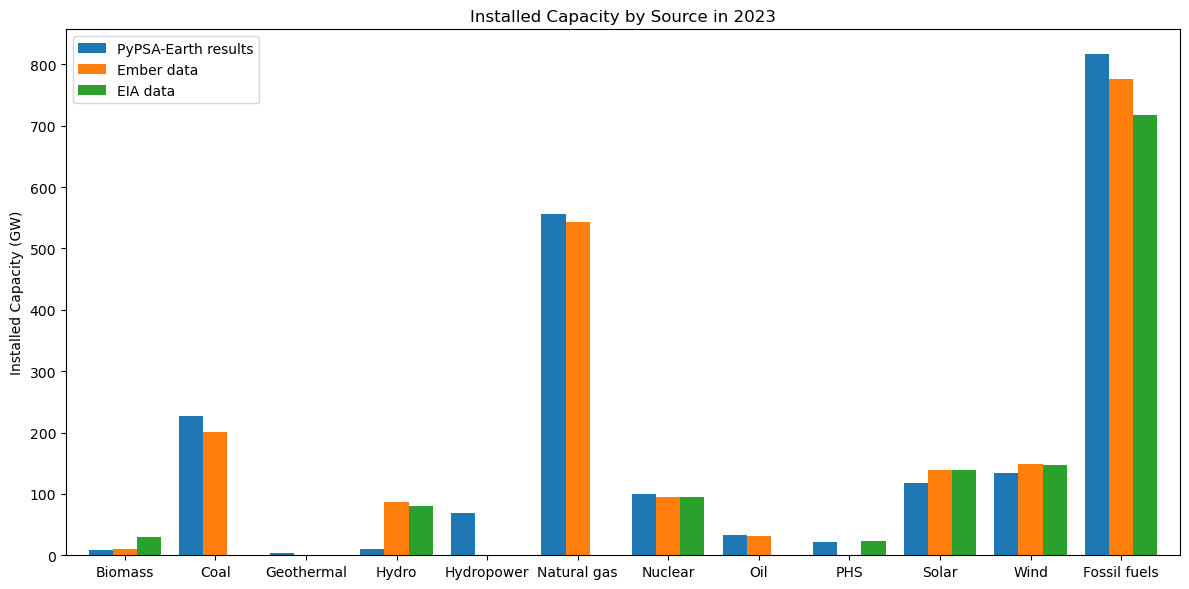

In [14]:
installed_capacity_df.plot(kind="bar", figsize=(12, 6), width=0.8)
plt.title(f"Installed Capacity by Source in {horizon}")
plt.ylabel("Installed Capacity (GW)")
plt.xticks(rotation=0)
plt.legend(loc='best')
plt.tight_layout()

---

## 3. Electricity generation

In this section, we compare the **annual electricity generation** by technology as reported by PyPSA-Earth, EIA, and Ember. This helps to identify any discrepancies in the modeled generation mix and total output.

In [15]:
# ember_data = load_ember_data()
generation_data_ember = get_generation_capacity_ember_detail(
        ember_data, three_country_code, horizon).round(2)
generation_data_ember.drop(['Load shedding', 'Other Fossil'], inplace=True)

eia_generation = get_data_EIA(eia_generation_path, country_code, horizon)
eia_generation = preprocess_eia_data_detail(eia_generation).round(2)

In [16]:
ac_balance = base_network.statistics.energy_balance().xs("AC", level=2)
ac_total = (ac_balance[ac_balance>0]/1e6).unstack().sum().rename({
        "CCGT": "Natural gas",  "OCGT": "Natural gas", "Csp": "Solar",
        "biomass EOP": "Biomass", "biomass": "Biomass", "coal": "Coal",
        "oil": "Oil", "urban central gas CHP": "Natural gas", 
        "urban central solid biomass CHP": "Biomass",
        "solar": "Solar", "Run of River": "Hydropower", "Reservoir & Dam": "Hydro",
        "Onshore Wind": "Wind", "offwind": "Wind", "Offshore Wind (DC)": "Wind",
    }).to_frame('PyPSA-Earth results').groupby(level=0).sum().round(2)

pypsa_gen_final = ac_total[ac_total > 0].dropna()
pypsa_gen_final.drop(['DC'], inplace=True)

In [17]:
generation_df = pd.concat(
    [pypsa_gen_final, generation_data_ember, eia_generation], axis=1).fillna(0)

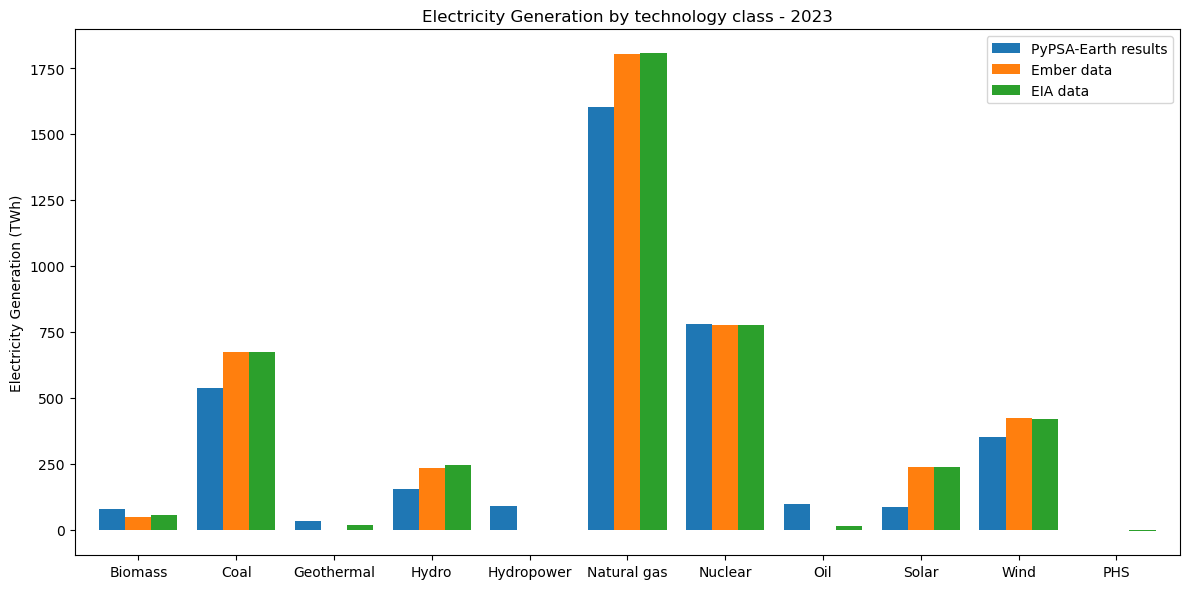

In [18]:
generation_df.plot(kind="bar", figsize=(12, 6), width=0.8)
plt.title(f"Electricity Generation by technology class - {horizon}")
plt.ylabel("Electricity Generation (TWh)")
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.tight_layout()

---

## 4. Electricity demand

Finally, we validate the **electricity demand** in the PyPSA network against the EIA and Ember datasets. This ensures that the modeled demand matches observed values for the base year.

### 4.1 Total electricity demand

*Total electricity demand in PyPSA-Earth (US) uses NREL as a reference (see the `scenario_analysis_single` notebook.*

### 4.2 State-wise Total Electricity Demand

*A bar plot showing the state-wise annual electricity demand for the base year (2023) to validate the quality of the spatial distribution of demand.*

In [19]:
demand_ember = get_demand_ember(ember_data, three_country_code, horizon)
_, pypsa_demand =compute_demand(base_network)

EIA_demand = preprocess_eia_demand(eia_demand_path, horizon)

In [20]:
base_demand_grid_region, base_demand_state = compute_demand(base_network)

In [21]:
demand_total =  pd.concat([EIA_demand, base_demand_state.sum(axis=1)], axis=1).rename({0: 'PyPSA-Earth'}, axis=1)

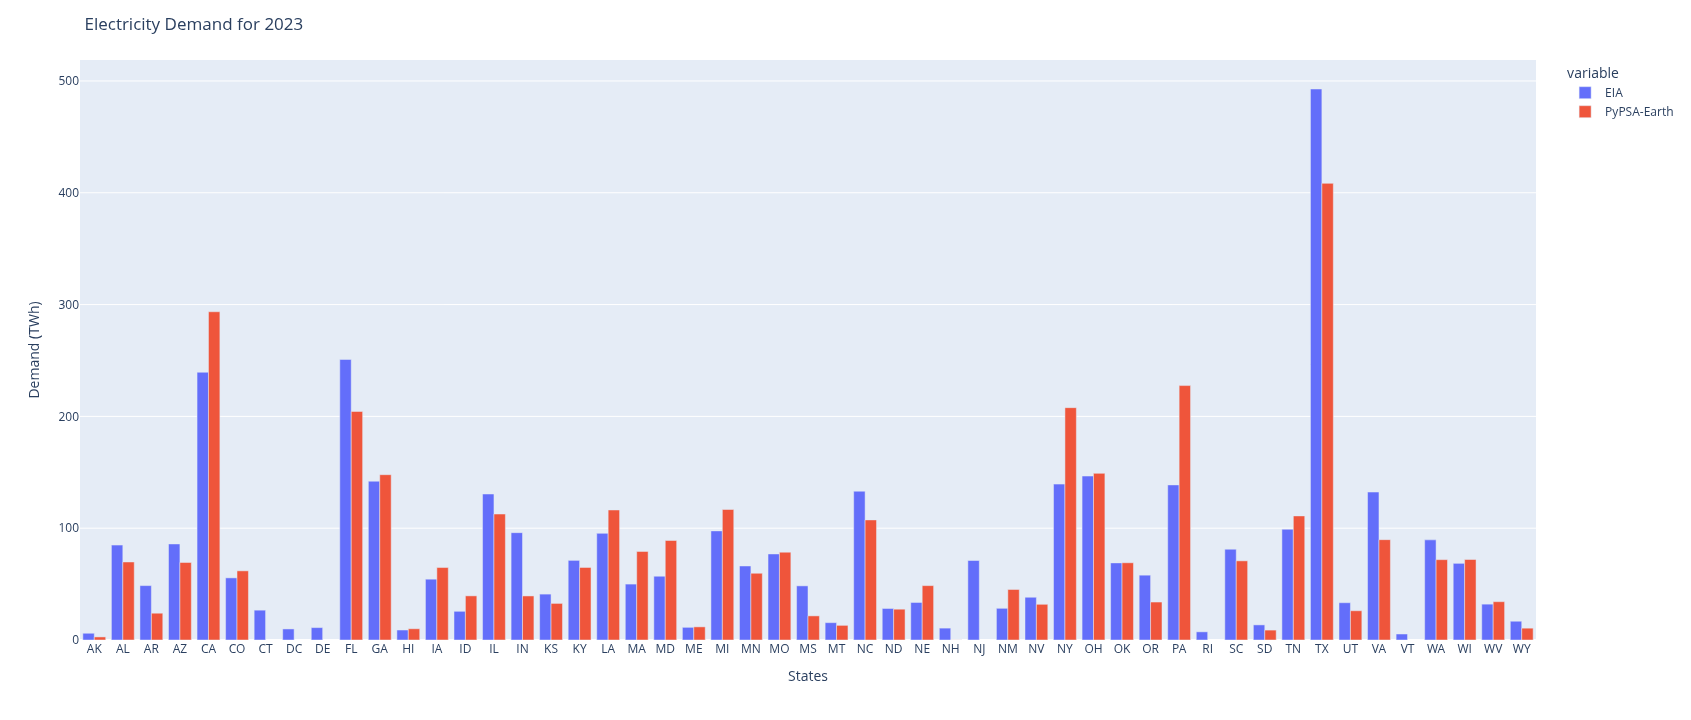

In [22]:
fig = px.bar(demand_total, barmode='group')
fig.update_layout(width=2500, 
                  height=700, 
                  yaxis_title='Demand (TWh)',
                  xaxis_title='States',
                  title=f'Electricity Demand for {horizon}')
fig.show()

In [23]:
base_demand_grid_region.T

region,Alaska,California,Delta,Florida,Hawaii,Mid-Atlantic,Midwest,Mountain,New England,New York,Northwest,Plains,Southeast,Southwest,Texas
carrier,,,,,,,,,,,,,,,
AC,0.79,93.45,62.43,86.00,3.21,294.25,175.19,49.63,31.86,68.20,64.13,112.19,224.31,56.55,149.50
agriculture electricity,0.06,5.55,1.62,2.17,0.25,10.13,7.09,3.56,1.76,4.36,2.50,3.98,8.33,2.30,3.64
industry electricity,1.10,69.15,38.91,17.47,3.36,153.96,88.76,36.51,26.10,67.34,26.61,48.15,77.29,18.16,59.59
land transport EV,0.08,6.66,1.90,2.49,0.29,12.41,8.81,4.44,2.20,5.42,3.11,4.83,9.86,2.75,4.25
rail transport electricity,0.01,0.54,0.16,0.21,0.02,0.97,0.69,0.34,0.17,0.43,0.24,0.40,0.80,0.23,0.35
services electricity,0.71,85.03,56.79,78.25,2.92,267.71,159.39,45.15,28.98,62.05,58.34,102.08,204.06,51.45,136.01


In [24]:
base_demand_state.T

region,AK,AL,AR,AZ,CA,CO,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NH,NM,NV,NY,OH,OK,OR,PA,SC,SD,TN,TX,UT,VA,WA,WI,WV,WY
carrier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AC,0.79,30.60,11.03,31.64,100.66,23.92,90.43,64.14,3.21,27.06,14.73,44.61,16.33,11.91,25.73,42.05,27.68,34.03,4.18,50.51,24.26,31.82,9.35,5.27,47.59,11.81,19.60,0.00,17.63,11.61,68.20,60.49,31.07,15.80,82.08,30.88,3.34,46.67,173.38,11.57,40.06,29.09,27.56,12.66,4.66
agriculture electricity,0.06,0.70,0.22,0.99,7.12,1.38,3.06,2.46,0.25,0.91,1.09,1.61,0.65,0.59,1.03,1.14,1.51,1.37,0.25,1.47,0.77,1.15,0.26,0.17,1.52,0.31,0.74,0.00,0.98,0.93,4.36,2.14,0.56,0.31,3.65,1.11,0.17,1.65,4.39,0.35,0.94,1.01,1.41,0.48,0.08
industry electricity,1.10,9.75,2.40,6.68,84.92,12.93,24.83,19.77,3.36,11.01,8.79,23.72,6.71,8.62,13.41,33.39,22.85,20.86,3.18,16.83,11.53,15.12,3.12,2.63,13.06,4.26,9.41,0.07,9.28,7.61,67.34,28.56,8.45,3.05,62.33,9.29,2.08,18.06,67.37,3.25,11.06,13.95,16.03,8.96,1.48
land transport EV,0.08,0.82,0.26,1.17,8.60,1.72,3.53,2.90,0.29,1.12,1.36,1.98,0.79,0.71,1.26,1.33,1.87,1.66,0.32,1.84,0.97,1.39,0.31,0.21,1.81,0.39,0.97,0.01,1.16,1.13,5.42,2.62,0.66,0.39,4.48,1.31,0.22,1.98,5.14,0.44,1.14,1.25,1.79,0.59,0.11
rail transport electricity,0.01,0.07,0.02,0.10,0.69,0.13,0.30,0.23,0.02,0.09,0.10,0.16,0.06,0.06,0.10,0.11,0.15,0.13,0.02,0.14,0.08,0.11,0.03,0.02,0.14,0.04,0.07,0.00,0.10,0.09,0.43,0.20,0.06,0.03,0.35,0.11,0.02,0.16,0.42,0.03,0.09,0.10,0.13,0.05,0.01
services electricity,0.71,27.84,10.03,28.79,91.59,21.77,82.28,58.35,2.92,24.62,13.40,40.59,14.86,10.84,23.41,38.26,25.18,30.96,3.80,45.94,22.07,28.96,8.50,4.79,43.29,10.75,17.83,0.00,16.04,10.56,62.05,55.04,28.27,14.38,74.67,28.09,3.04,42.46,157.73,10.52,36.45,26.46,25.07,11.52,4.24


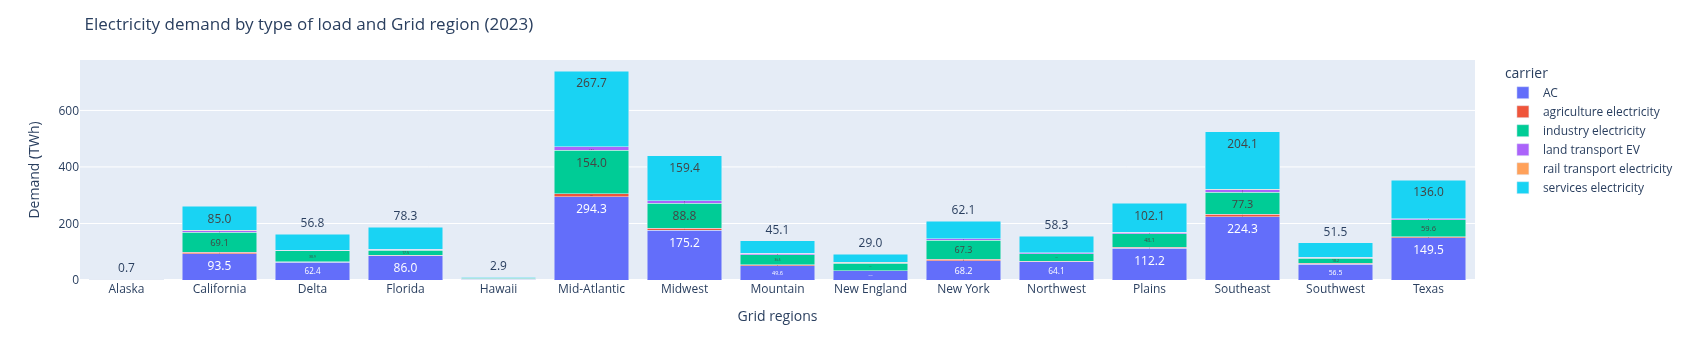

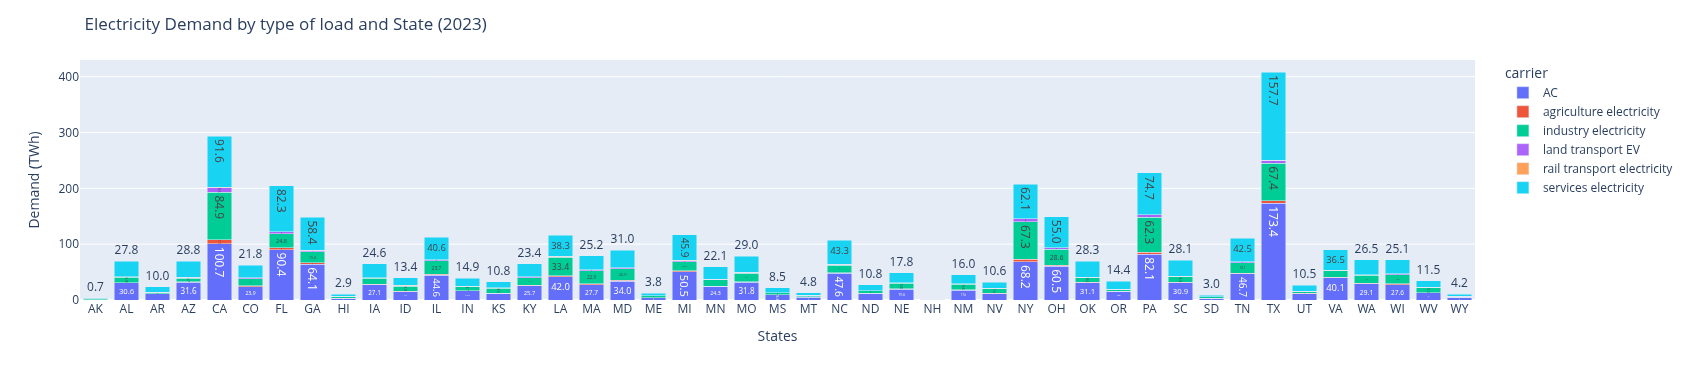

In [25]:
fig1 = px.bar(base_demand_grid_region, barmode='stack', text_auto='.1f')
fig1.update_layout(width=1100, yaxis_title='Demand (TWh)', xaxis_title='Grid regions', title='Electricity demand by type of load and Grid region (2023)')
fig1.show()

fig1 = px.bar(base_demand_state, barmode='stack', text_auto='.1f')
fig1.update_layout(width=3000, yaxis_title='Demand (TWh)', xaxis_title='States', title='Electricity Demand by type of load and State (2023)')
fig1.show()